In [193]:
from prophet import Prophet
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam
import prophet
warnings.filterwarnings('ignore')

In [194]:
czech  = pd.read_csv('univariate_models/univariate_df_Czechia.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)
eston  = pd.read_csv('univariate_models/univariate_df_Estonia.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)
franc  = pd.read_csv('univariate_models/univariate_df_France.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)
malay  = pd.read_csv('univariate_models/univariate_df_Malaysia.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)
belgi  = pd.read_csv('univariate_models/univariate_df_Belgium.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)
chile  = pd.read_csv('univariate_models/univariate_df_Chile.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)
irela  = pd.read_csv('univariate_models/univariate_df_Ireland.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)
israe  = pd.read_csv('univariate_models/univariate_df_Israel.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)
italy  = pd.read_csv('univariate_models/univariate_df_Italy.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)
us  = pd.read_csv('univariate_models/univariate_df_United_States.csv',usecols=[1,2],  parse_dates=[0]).reset_index(drop=True)

#sort index
for x in [czech, eston, franc, malay,belgi, chile, irela, israe, italy, us]:
    x = x.sort_index()

train_size = int(len(czech) * 0.8)
czech_train, czech_test = czech[0:train_size].rename(columns={'date': 'ds', 'new_deaths': 'y'}), czech[train_size:].rename(columns={'date': 'ds', 'new_deaths': 'y'})
eston_train, eston_test = eston[0:train_size].rename(columns={'date': 'ds', 'new_deaths': 'y'}), eston[train_size:].rename(columns={'date': 'ds', 'new_deaths': 'y'})
franc_train, franc_test = franc[0:train_size].rename(columns={'date': 'ds', 'new_deaths': 'y'}), franc[train_size:].rename(columns={'date': 'ds', 'new_deaths': 'y'})
malay_train, malay_test = malay[0:train_size].rename(columns={'date': 'ds', 'new_deaths': 'y'}), malay[train_size:].rename(columns={'date': 'ds', 'new_deaths': 'y'})
belgi_train, belgi_test = belgi[0:train_size].rename(columns={'date': 'ds', 'new_deaths': 'y'}), belgi[train_size:].rename(columns={'date': 'ds', 'new_deaths': 'y'})
chile_train, chile_test = chile[0:train_size].rename(columns={'date': 'ds', 'new_deaths': 'y'}), chile[train_size:].rename(columns={'date': 'ds', 'new_deaths': 'y'})
irela_train, irela_test = irela[0:train_size].rename(columns={'date': 'ds', 'new_deaths': 'y'}), irela[train_size:].rename(columns={'date': 'ds', 'new_deaths': 'y'})
israe_train, israe_test = israe[0:train_size].rename(columns={'date': 'ds', 'new_deaths': 'y'}), israe[train_size:].rename(columns={'date': 'ds', 'new_deaths': 'y'})
italy_train, italy_test = italy[0:train_size].rename(columns={'date': 'ds', 'new_deaths': 'y'}), italy[train_size:].rename(columns={'date': 'ds', 'new_deaths': 'y'})
us_train, us_test = us[0:train_size].rename(columns={'date': 'ds', 'new_deaths': 'y'}), us[train_size:].rename(columns={'date': 'ds', 'new_deaths': 'y'})
czech_train

,ds,y
0,2020-03-01,0.0
1,2020-03-08,0.0
2,2020-03-15,0.0
3,2020-03-22,0.0
4,2020-03-29,17.0
...,...,...
156,2023-02-26,48.0
157,2023-03-05,43.0
158,2023-03-12,36.0
159,2023-03-19,57.0


In [195]:
def mean_absolute_scaled_error(y_true, y_pred):
    naive_forecast = y_true[:-1]
    y_true_insample = y_true[1:]
    insample_error = np.abs(y_true_insample - naive_forecast)
    # Calculate the forecast errors
    forecast_error = np.abs(y_true - y_pred)
    # Calculate the MASE
    mase = np.mean(forecast_error) / np.mean(insample_error)
    return mase

metrics_df = pd.DataFrame(columns=['Model', 'MAE', 'MASE'])

In [196]:
train, test = czech_train, czech_test
model_baseline = Prophet()
model_baseline.fit(train)
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W') # periods are 41


17:10:41 - cmdstanpy - INFO - Chain [1] start processing
17:10:42 - cmdstanpy - INFO - Chain [1] done processing


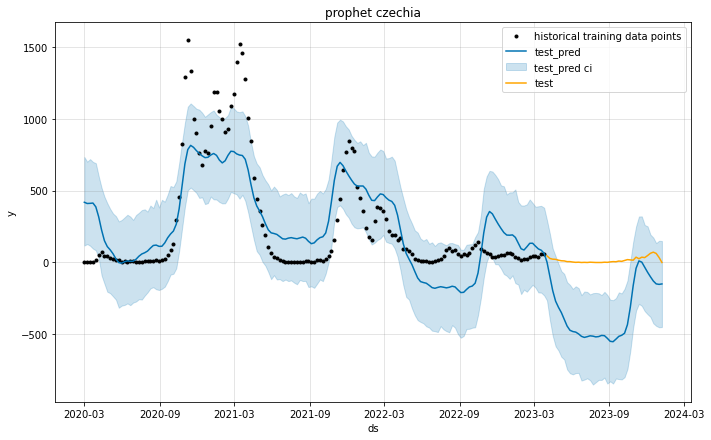

In [197]:
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline);

plt.plot(test['ds'], test['y'], color = 'orange')
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
plt.legend(['historical training data points', 'test_pred','test_pred ci','test'])
plt.title('prophet czechia')
mae = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(forecast_baseline['yhat'][161:]))
metrics_df.loc[len(metrics_df)] = ['base prophet czech',mae, mase]

In [198]:
len(model_baseline.changepoints)

25

17:10:43 - cmdstanpy - INFO - Chain [1] start processing
17:10:43 - cmdstanpy - INFO - Chain [1] done processing


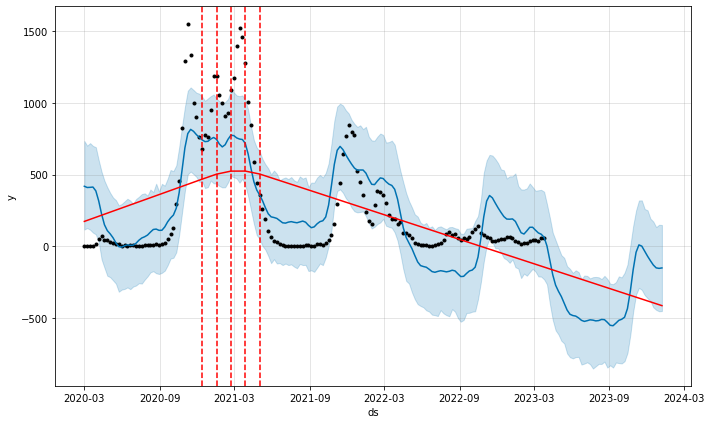

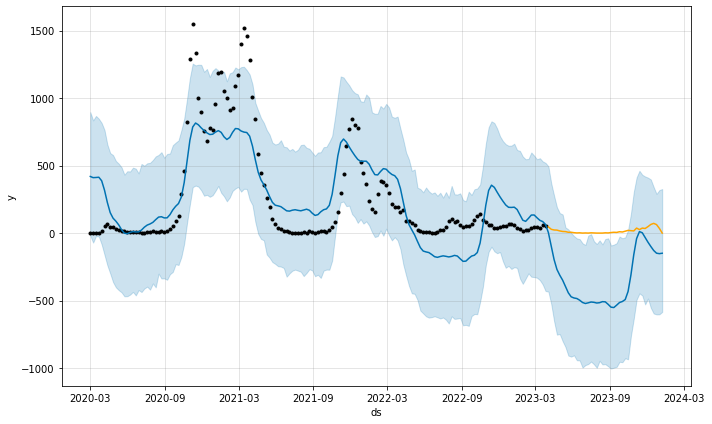

In [199]:
from prophet.plot import add_changepoints_to_plot

fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points


model_changepoint = Prophet(interval_width=0.95, n_changepoints=25)
model_changepoint.fit(train)
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
forecast_changepoint = model_changepoint.predict(future_changepoint)
model_changepoint.plot(forecast_changepoint);
plt.plot(test['ds'], test['y'], color = 'orange')
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
mae = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(performance_changepoint['yhat']))
metrics_df.loc[len(metrics_df)] = ['base prophet czech',mae, mase]

17:10:44 - cmdstanpy - INFO - Chain [1] start processing
17:10:44 - cmdstanpy - INFO - Chain [1] done processing
17:10:44 - cmdstanpy - INFO - Chain [1] start processing
17:10:44 - cmdstanpy - INFO - Chain [1] done processing


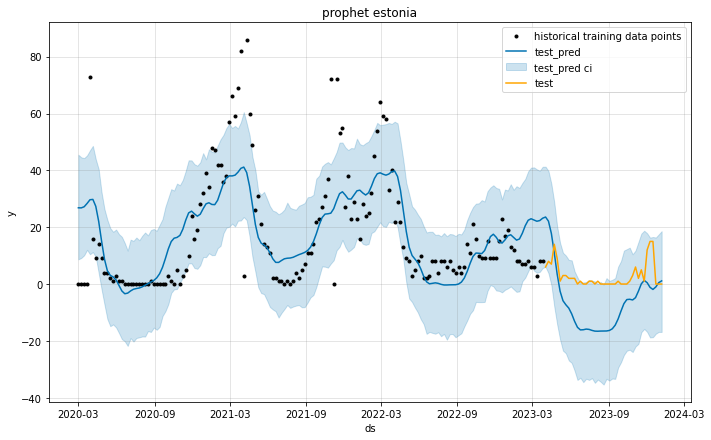

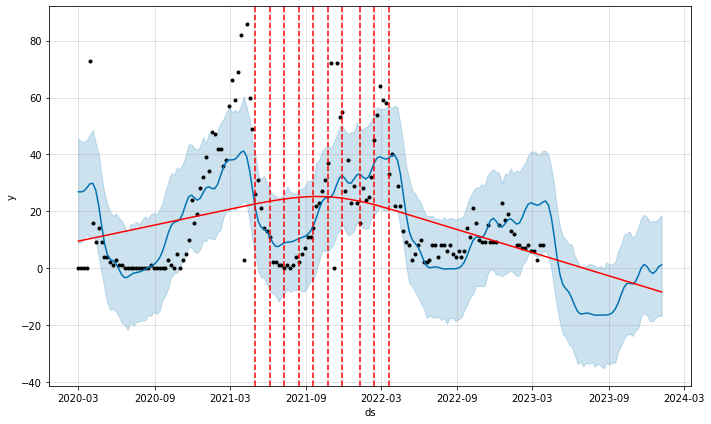

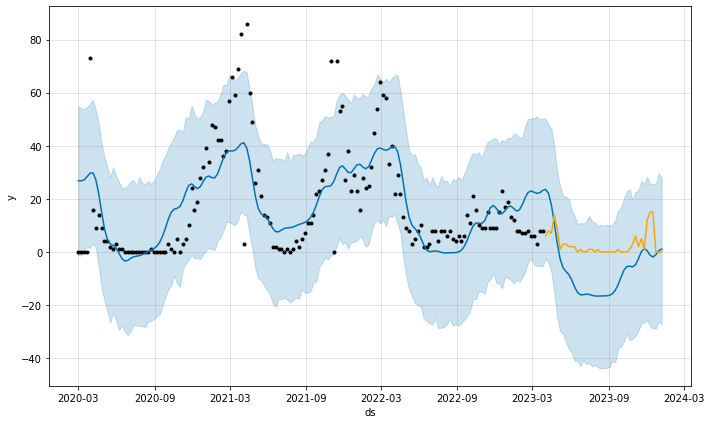

In [200]:
train, test = eston_train, eston_test
model_baseline = Prophet()
model_baseline.fit(train)
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W') # periods are 41
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline);

plt.plot(test['ds'], test['y'], color = 'orange')
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
plt.legend(['historical training data points', 'test_pred','test_pred ci','test'])
plt.title('prophet estonia')
len(model_baseline.changepoints)
from prophet.plot import add_changepoints_to_plot

fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points


model_changepoint = Prophet(interval_width=0.95, n_changepoints=25)
model_changepoint.fit(train)
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
forecast_changepoint = model_changepoint.predict(future_changepoint)
model_changepoint.plot(forecast_changepoint);
plt.plot(test['ds'], test['y'], color = 'orange')
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
mae = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(performance_changepoint['yhat']))
metrics_df.loc[len(metrics_df)] = ['base prophet estonia',mae, mase]

17:10:45 - cmdstanpy - INFO - Chain [1] start processing
17:10:45 - cmdstanpy - INFO - Chain [1] done processing
17:10:46 - cmdstanpy - INFO - Chain [1] start processing
17:10:46 - cmdstanpy - INFO - Chain [1] done processing


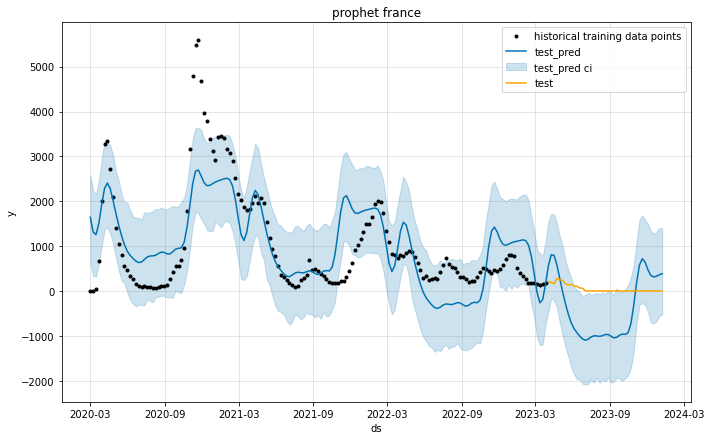

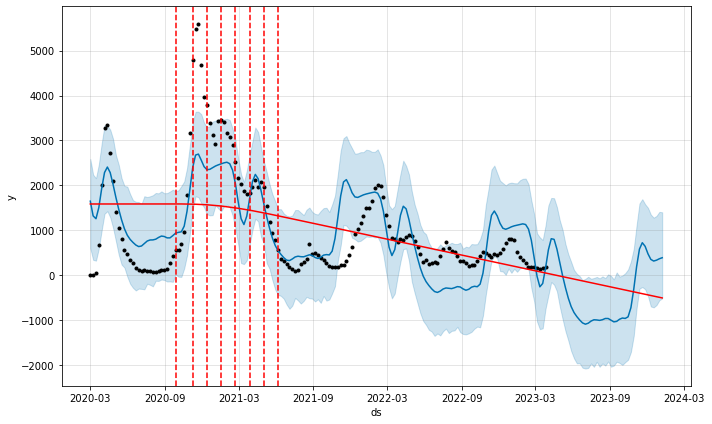

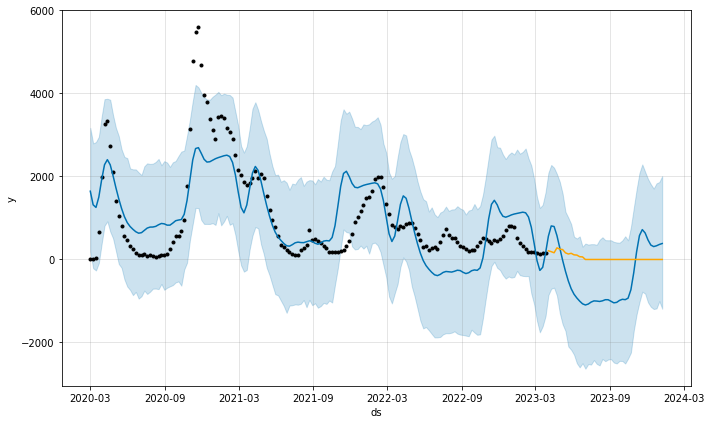

In [201]:
train, test = franc_train, franc_test
model_baseline = Prophet()
model_baseline.fit(train)
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W') # periods are 41
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline);

plt.plot(test['ds'], test['y'], color = 'orange')
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
plt.legend(['historical training data points', 'test_pred','test_pred ci','test'])
plt.title('prophet france')
len(model_baseline.changepoints)
from prophet.plot import add_changepoints_to_plot

fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points


model_changepoint = Prophet(interval_width=0.95, n_changepoints=25)
model_changepoint.fit(train)
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
forecast_changepoint = model_changepoint.predict(future_changepoint)
model_changepoint.plot(forecast_changepoint);
plt.plot(test['ds'], test['y'], color = 'orange')
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
mae = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(performance_changepoint['yhat']))
metrics_df.loc[len(metrics_df)] = ['base prophet france',mae, mase]

17:10:49 - cmdstanpy - INFO - Chain [1] start processing
17:10:49 - cmdstanpy - INFO - Chain [1] done processing
17:10:49 - cmdstanpy - INFO - Chain [1] start processing
17:10:49 - cmdstanpy - INFO - Chain [1] done processing


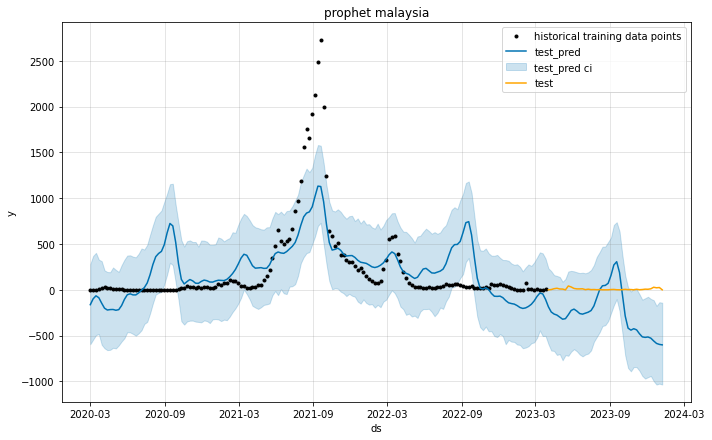

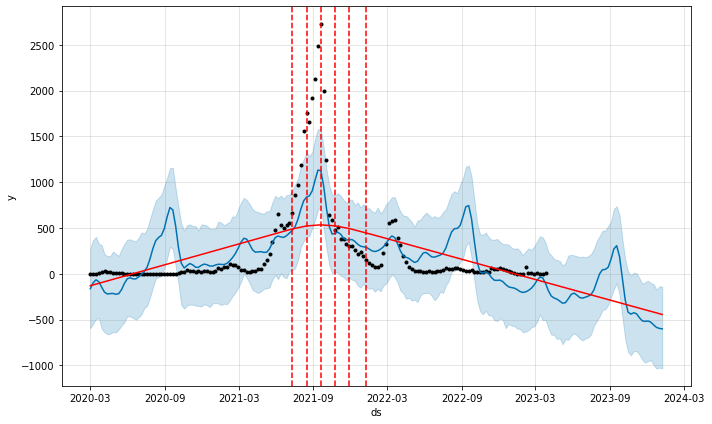

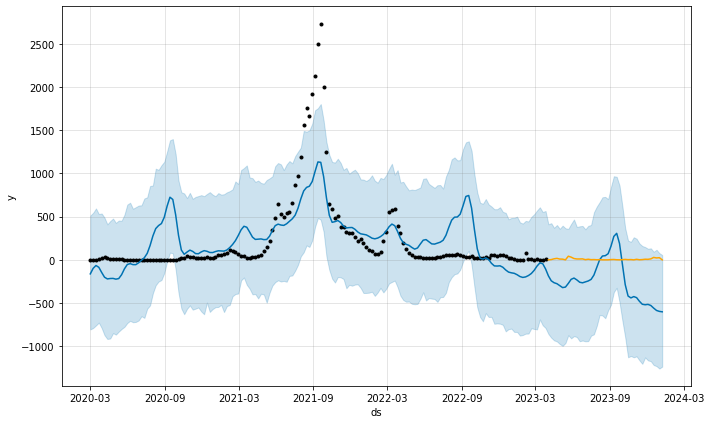

In [202]:
train, test = malay_train, malay_test
model_baseline = Prophet()
model_baseline.fit(train)
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W') # periods are 41
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline);

plt.plot(test['ds'], test['y'], color = 'orange')
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
plt.legend(['historical training data points', 'test_pred','test_pred ci','test'])

plt.title('prophet malaysia')
len(model_baseline.changepoints)
from prophet.plot import add_changepoints_to_plot

fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points


model_changepoint = Prophet(interval_width=0.95, n_changepoints=25)
model_changepoint.fit(train)
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
forecast_changepoint = model_changepoint.predict(future_changepoint)
model_changepoint.plot(forecast_changepoint);
plt.plot(test['ds'], test['y'], color = 'orange')
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
mae = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(performance_changepoint['yhat']))
metrics_df.loc[len(metrics_df)] = ['base prophet malaysia',mae, mase]

17:10:50 - cmdstanpy - INFO - Chain [1] start processing


17:10:50 - cmdstanpy - INFO - Chain [1] done processing
17:10:50 - cmdstanpy - INFO - Chain [1] start processing
17:10:50 - cmdstanpy - INFO - Chain [1] done processing


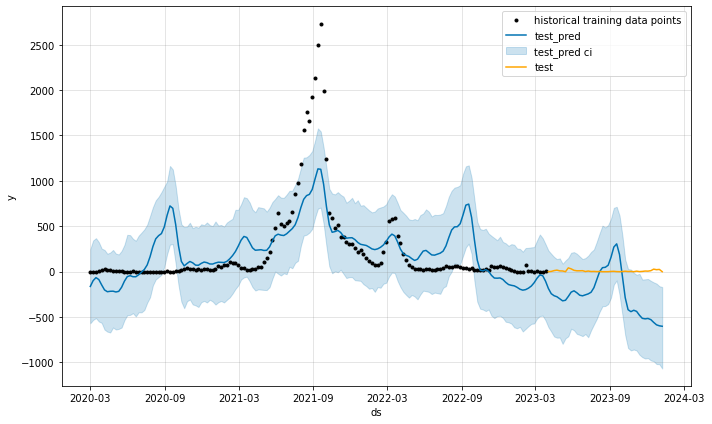

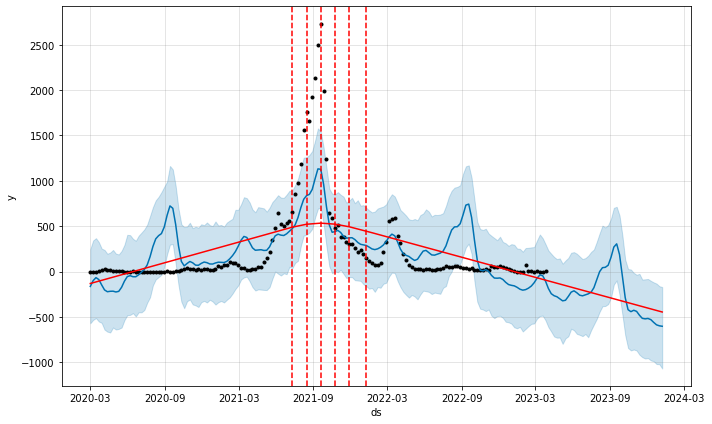

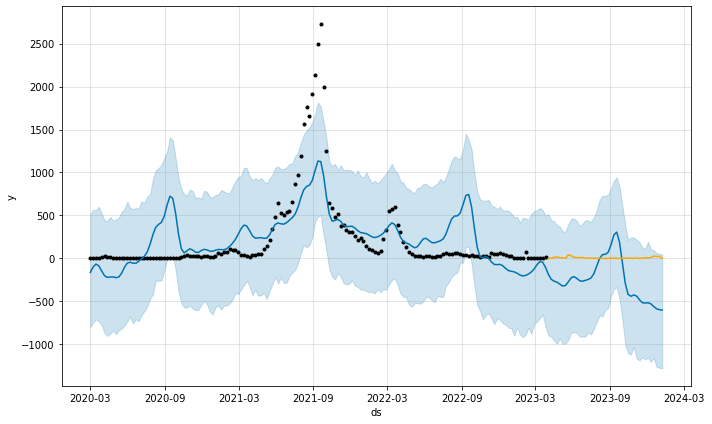

In [203]:
train, test = malay_train,malay_test
model_baseline = Prophet()
model_baseline.fit(train)
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W') # periods are 41
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline);

plt.plot(test['ds'], test['y'], color = 'orange')
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
plt.legend(['historical training data points', 'test_pred','test_pred ci','test'])

from prophet.plot import add_changepoints_to_plot

fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points


model_changepoint = Prophet(interval_width=0.95, n_changepoints=25)
model_changepoint.fit(train)
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
forecast_changepoint = model_changepoint.predict(future_changepoint)
model_changepoint.plot(forecast_changepoint);
plt.plot(test['ds'], test['y'], color = 'orange')
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
mae = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(performance_changepoint['yhat']))
metrics_df.loc[len(metrics_df)] = ['base prophet malaysia',mae, mase]

17:10:52 - cmdstanpy - INFO - Chain [1] start processing
17:10:52 - cmdstanpy - INFO - Chain [1] done processing
17:10:52 - cmdstanpy - INFO - Chain [1] start processing
17:10:52 - cmdstanpy - INFO - Chain [1] done processing


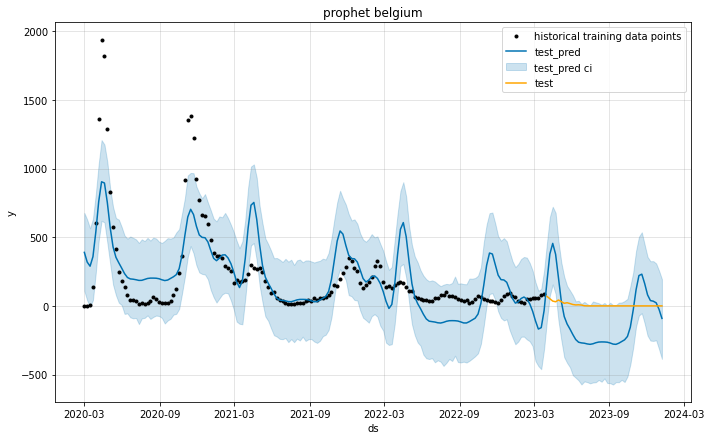

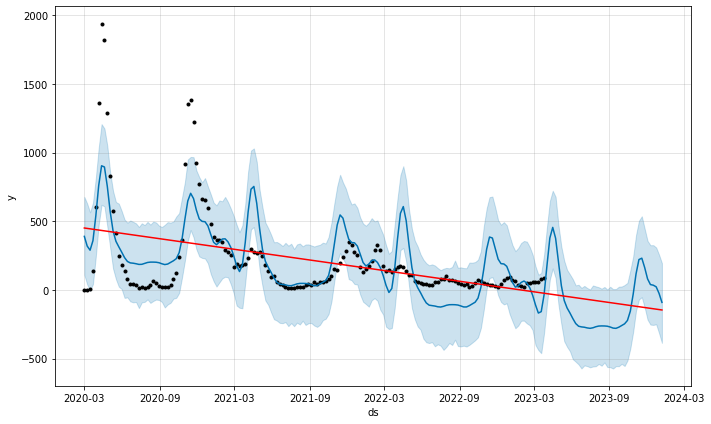

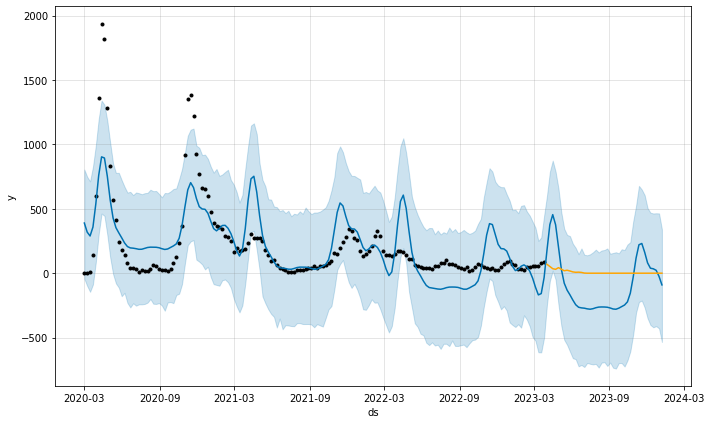

In [204]:
train, test = belgi_train, belgi_test
model_baseline = Prophet()
model_baseline.fit(train)
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W') # periods are 41
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline);

plt.plot(test['ds'], test['y'], color = 'orange')
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
plt.legend(['historical training data points', 'test_pred','test_pred ci','test'])
plt.title('prophet belgium')
len(model_baseline.changepoints)
from prophet.plot import add_changepoints_to_plot

fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points


model_changepoint = Prophet(interval_width=0.95, n_changepoints=25)
model_changepoint.fit(train)
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
forecast_changepoint = model_changepoint.predict(future_changepoint)
model_changepoint.plot(forecast_changepoint);
plt.plot(test['ds'], test['y'], color = 'orange')
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
mae = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(performance_changepoint['yhat']))
metrics_df.loc[len(metrics_df)] = ['base prophet belgium',mae, mase]

17:10:53 - cmdstanpy - INFO - Chain [1] start processing
17:10:53 - cmdstanpy - INFO - Chain [1] done processing
17:10:53 - cmdstanpy - INFO - Chain [1] start processing
17:10:54 - cmdstanpy - INFO - Chain [1] done processing


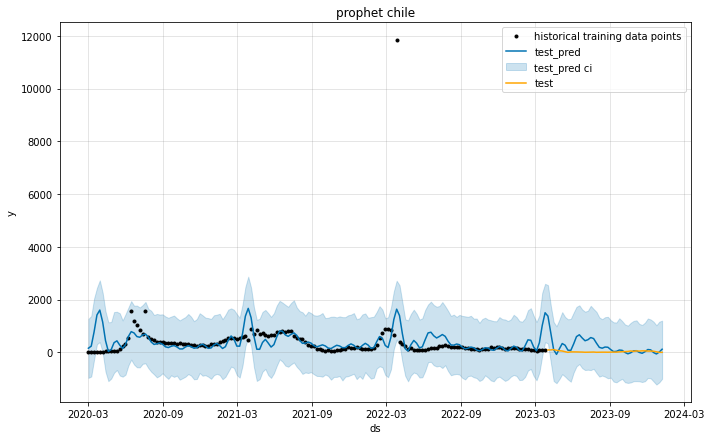

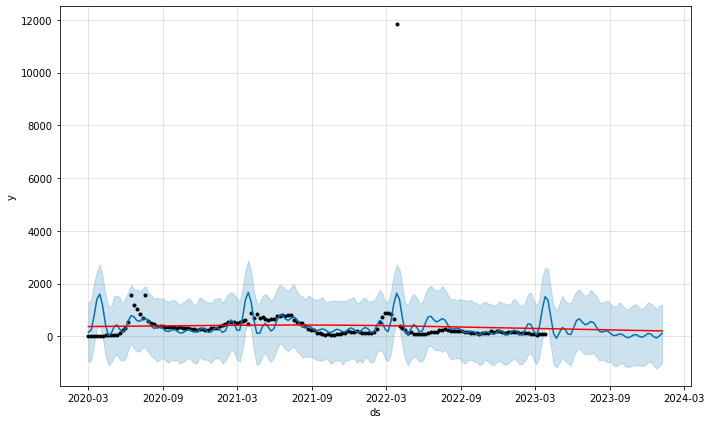

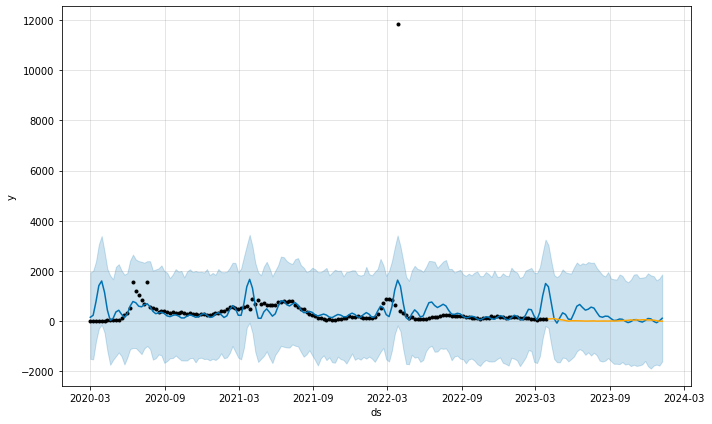

In [205]:
train, test = chile_train, chile_test
model_baseline = Prophet()
model_baseline.fit(train)
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W') # periods are 41
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline);

plt.plot(test['ds'], test['y'], color = 'orange')
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
plt.legend(['historical training data points', 'test_pred','test_pred ci','test'])
plt.title('prophet chile')
len(model_baseline.changepoints)
from prophet.plot import add_changepoints_to_plot

fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points


model_changepoint = Prophet(interval_width=0.95, n_changepoints=25)
model_changepoint.fit(train)
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
forecast_changepoint = model_changepoint.predict(future_changepoint)
model_changepoint.plot(forecast_changepoint);
plt.plot(test['ds'], test['y'], color = 'orange')
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
mae = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(performance_changepoint['yhat']))
metrics_df.loc[len(metrics_df)] = ['base prophet chile',mae, mase]

17:10:54 - cmdstanpy - INFO - Chain [1] start processing
17:10:54 - cmdstanpy - INFO - Chain [1] done processing
17:10:55 - cmdstanpy - INFO - Chain [1] start processing
17:10:55 - cmdstanpy - INFO - Chain [1] done processing


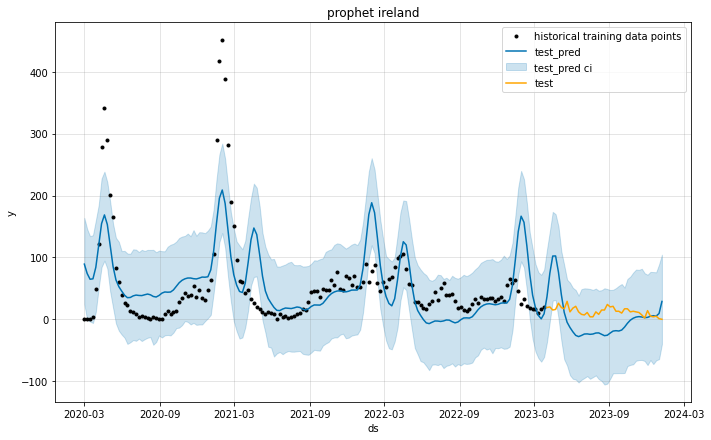

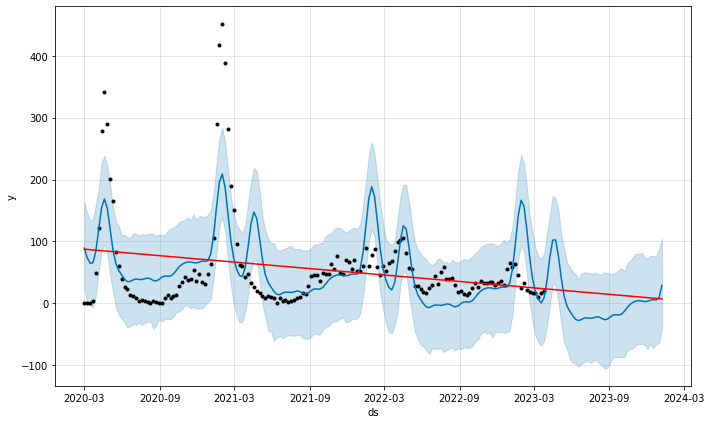

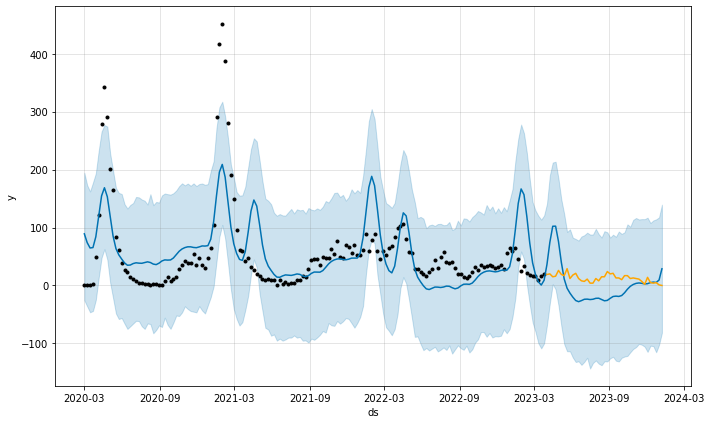

In [206]:
train, test = irela_train, irela_test
model_baseline = Prophet()
model_baseline.fit(train)
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W') # periods are 41
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline);
plt.legend(['historical training data points', 'test','test ci','test_pred'])

plt.plot(test['ds'], test['y'], color = 'orange')
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
plt.legend(['historical training data points', 'test_pred','test_pred ci','test'])
plt.title('prophet ireland')
from prophet.plot import add_changepoints_to_plot

fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points


model_changepoint = Prophet(interval_width=0.95, n_changepoints=25)
model_changepoint.fit(train)
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
forecast_changepoint = model_changepoint.predict(future_changepoint)
model_changepoint.plot(forecast_changepoint);
plt.plot(test['ds'], test['y'], color = 'orange')
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
mae = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(performance_changepoint['yhat']))
metrics_df.loc[len(metrics_df)] = ['base prophet ireland',mae, mase]

17:10:55 - cmdstanpy - INFO - Chain [1] start processing
17:10:55 - cmdstanpy - INFO - Chain [1] done processing
17:10:56 - cmdstanpy - INFO - Chain [1] start processing
17:10:56 - cmdstanpy - INFO - Chain [1] done processing


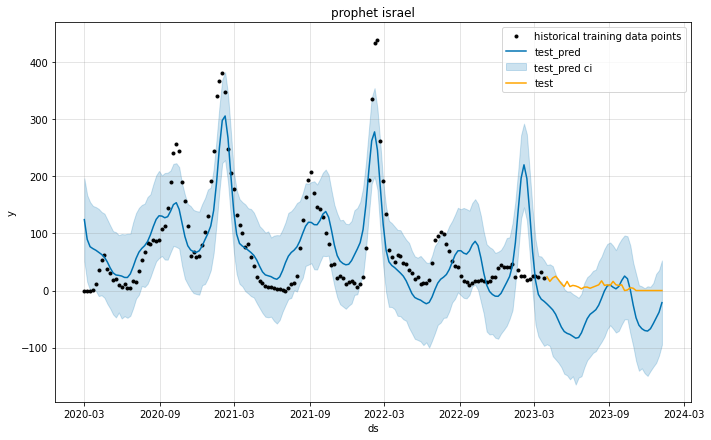

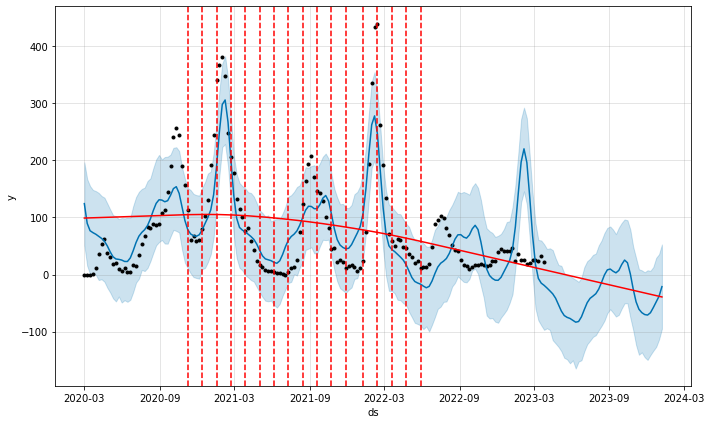

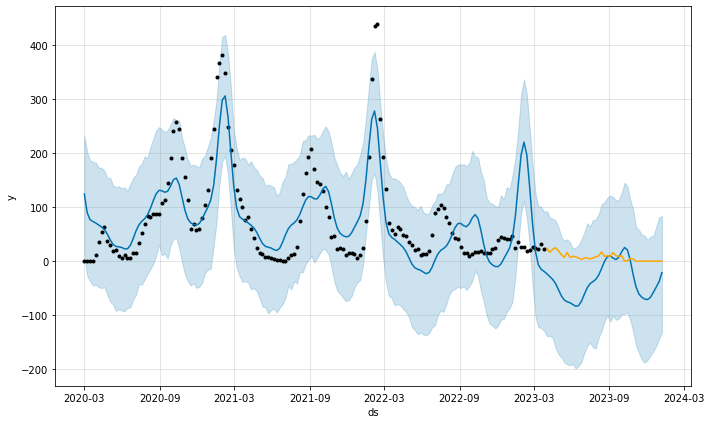

In [207]:
train, test = israe_train, israe_test
model_baseline = Prophet()
model_baseline.fit(train)
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W') # periods are 41
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline);

plt.plot(test['ds'], test['y'], color = 'orange')
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

len(model_baseline.changepoints)
plt.legend(['historical training data points', 'test_pred','test_pred ci','test'])
plt.title('prophet israel')
from prophet.plot import add_changepoints_to_plot

fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points


model_changepoint = Prophet(interval_width=0.95, n_changepoints=25)
model_changepoint.fit(train)
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
forecast_changepoint = model_changepoint.predict(future_changepoint)
model_changepoint.plot(forecast_changepoint);
plt.plot(test['ds'], test['y'], color = 'orange')
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
mae = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(performance_changepoint['yhat']))
metrics_df.loc[len(metrics_df)] = ['base prophet israel',mae, mase]

17:10:57 - cmdstanpy - INFO - Chain [1] start processing
17:10:57 - cmdstanpy - INFO - Chain [1] done processing
17:10:57 - cmdstanpy - INFO - Chain [1] start processing
17:10:57 - cmdstanpy - INFO - Chain [1] done processing


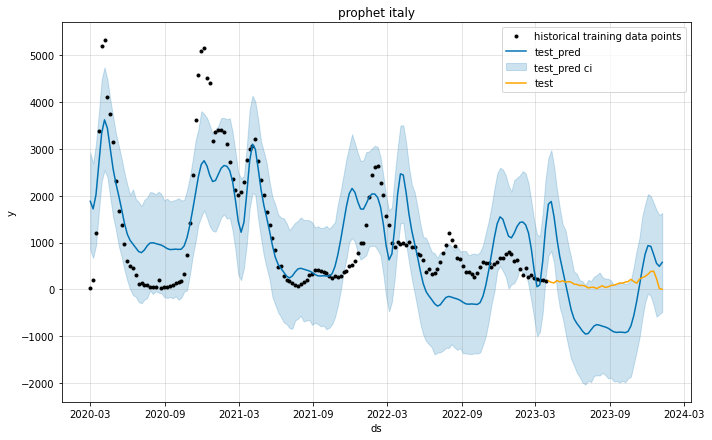

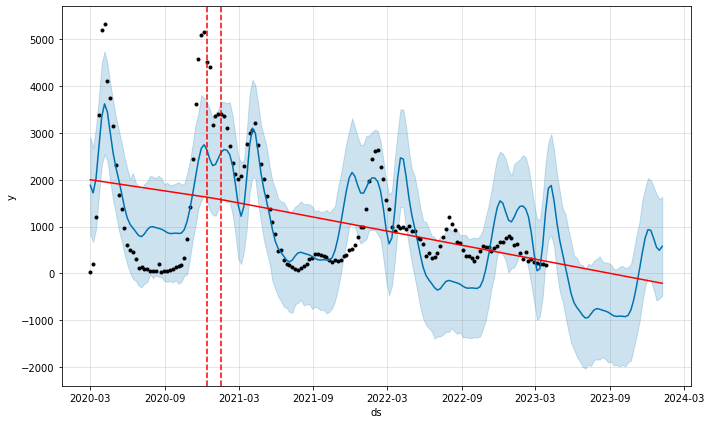

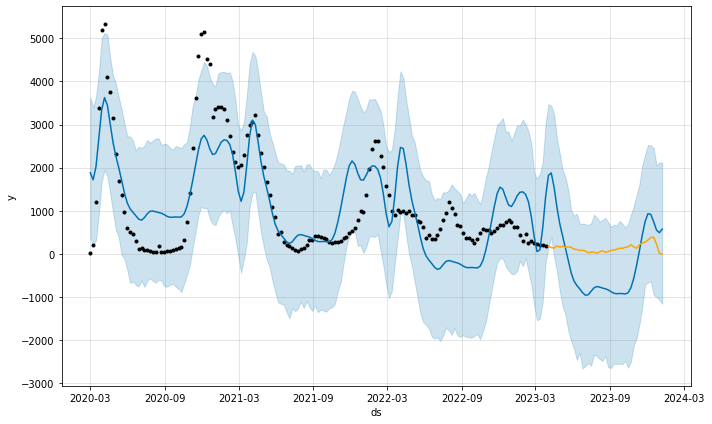

In [208]:
train, test = italy_train, italy_test
model_baseline = Prophet()
model_baseline.fit(train)
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W') # periods are 41
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline);

plt.plot(test['ds'], test['y'], color = 'orange')
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')

len(model_baseline.changepoints)
from prophet.plot import add_changepoints_to_plot
plt.legend(['historical training data points', 'test_pred','test_pred ci','test'])
plt.title('prophet italy')
fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points


model_changepoint = Prophet(interval_width=0.95, n_changepoints=25)
model_changepoint.fit(train)
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
forecast_changepoint = model_changepoint.predict(future_changepoint)
model_changepoint.plot(forecast_changepoint);
plt.plot(test['ds'], test['y'], color = 'orange')
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
mae = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(performance_changepoint['yhat']))
metrics_df.loc[len(metrics_df)] = ['base prophet italy',mae, mase]

17:10:58 - cmdstanpy - INFO - Chain [1] start processing
17:10:58 - cmdstanpy - INFO - Chain [1] done processing
17:10:58 - cmdstanpy - INFO - Chain [1] start processing
17:10:58 - cmdstanpy - INFO - Chain [1] done processing


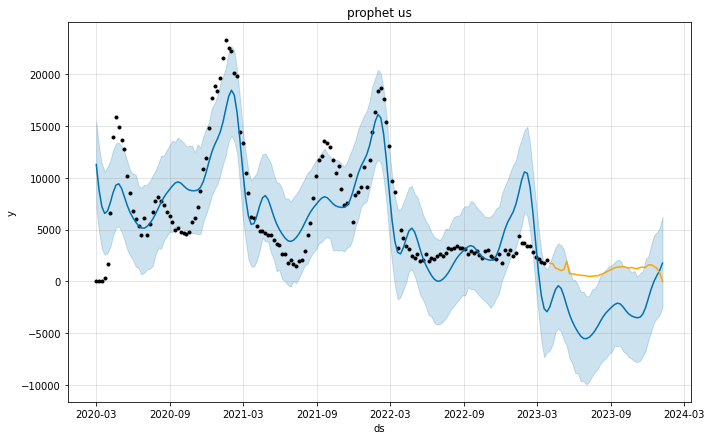

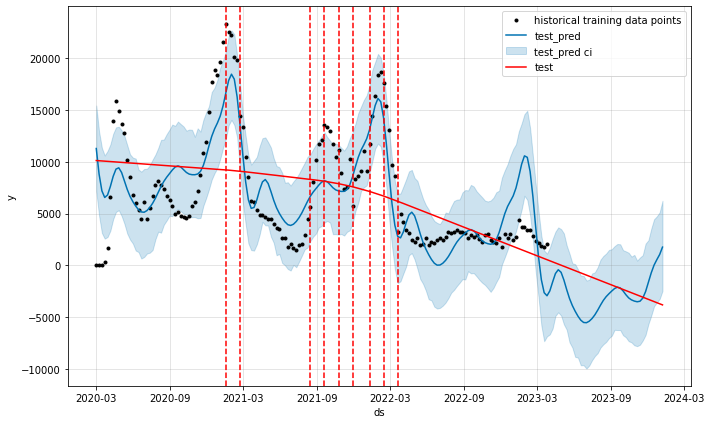

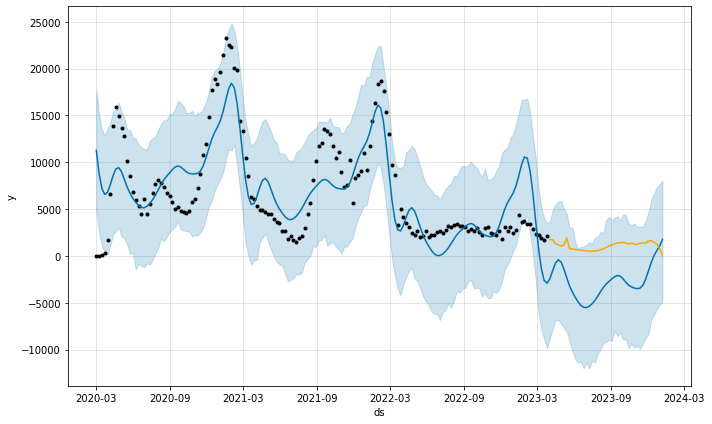

In [209]:
train, test = us_train, us_test
model_baseline = Prophet()
model_baseline.fit(train)
future_baseline = model_baseline.make_future_dataframe(periods=41, freq='W') # periods are 41
# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)
# Visualize the forecast
model_baseline.plot(forecast_baseline);

plt.plot(test['ds'], test['y'], color = 'orange')
plt.title('prophet us')
len(model_baseline.changepoints)
from prophet.plot import add_changepoints_to_plot

fig = model_baseline.plot(forecast_baseline)
a = add_changepoints_to_plot(fig.gca(), model_baseline, forecast_baseline)
#1 observed change points
plt.legend(['historical training data points', 'test_pred','test_pred ci','test'])


model_changepoint = Prophet(interval_width=0.95, n_changepoints=25)
model_changepoint.fit(train)
future_changepoint = model_changepoint.make_future_dataframe(periods=41, freq='W')
forecast_changepoint = model_changepoint.predict(future_changepoint)
model_changepoint.plot(forecast_changepoint);
plt.plot(test['ds'], test['y'], color = 'orange')
performance_changepoint = pd.merge(test, forecast_changepoint[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-41:], on='ds')
mae = mean_absolute_error(performance_changepoint['y'], performance_changepoint['yhat'])
mase = mean_absolute_scaled_error(np.array(test['y']), np.array(performance_changepoint['yhat']))
metrics_df.loc[len(metrics_df)] = ['base prophet us',mae, mase]

metrics_df
metrics_df.to_csv('prophetmetrics_data.csv', index=False)